**This Titanic case competition's goal is to predict whether a passenger would survive the crash of Titanic based on different features such as passenger class, gender, fare fee, and so on. It is a binary classification problem, so I will use classification models such as logistic regression, support vector machine, random forest, K-Nearest Neighbors, and XGBoost to compare which model performs best. I will also use Randomized Search Grid Search to fine-tune hyperparameters to improve model performance.**

My notebook will follow the outline below, which helps me to organize my thoughts and makes this notebook easier to read and follow.

1. **Data Importing**: Read the data file and combine training and test data together

2. **Exploratory Data Analysis**: In this section, I will understand the dataset by using .corr(), .describe(), pivot table, and visualization tools. I will find relationships between variables and some interesting insights from the data.

3. **Feature Engineering**: There are less than 15 variables in this dataset, so I will create more variables by creating dummy variables and customizing a couple of features. Hopefully, the new features created could help boost the model performance.

4. **Data Processing**: Standardize numerical variables. Getting data ready for modeling

5. **Model Building**: I will use baseline models without fine-tuning hyperparameters

6. **Hyperparameters Fine-tuning**: I will fine-tune hyperparameters of the models I use

7. **Results**: I will compare models' performance and use the best model to predict the test dataset.

In [195]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

## Data Importing

In [158]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
data = pd.concat([titanic_train, titanic_test]).reset_index()
data.drop('index', axis=1, inplace=True)

# Dropping the 'PassengerId' column
train.drop('PassengerId', axis=1, inplace=True)
test.drop('PassengerId', axis=1, inplace=True)
data.drop('PassengerId', axis=1, inplace=True)

## Exploratory Data Analysis

In this section, I will perform EDA on the training dataset first because only data in the training dataset are labeled, so I can find the relationship between variables and the target variable. Also, insights from the training dataset also apply to the test dataset. 

A simple guideline for basic EDA:

**For Numerical Variables**:

1. Using .corr(), .describe() to learn corrlation and central tendency of data.
2. Pivot table to learn mean numeric values for those who survived and not.
3. Visualize the distribution of data.

**For Categorical Variables**:

1. Using countplot to visualize the balance of each class.
2. Pivot table to find the relationship between each category and survival status.

In [15]:
# Checking for missing values and data types
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [14]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Because Age, SibSp, Parch, and Fare have very different ranges of values, using **StandardScaler** later might decrease model's bias towards Fare and Age.

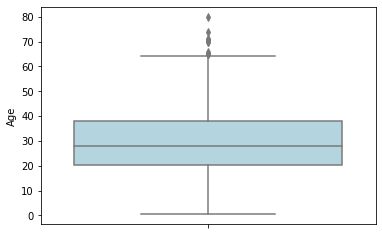

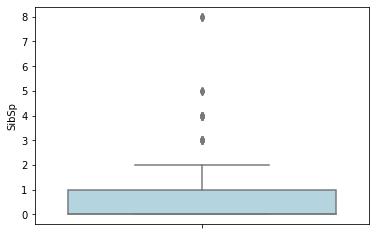

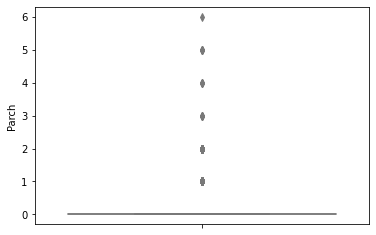

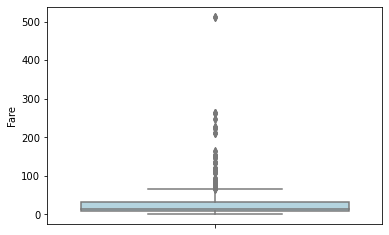

In [18]:
for column in ['Age', 'SibSp', 'Parch', 'Fare']:
    sns.boxplot(data=train, y=column, color='lightblue')
    plt.show()

          Survived    Pclass       Age     SibSp     Parch      Fare
Survived  1.000000 -0.338481 -0.077221 -0.035322  0.081629  0.257307
Pclass   -0.338481  1.000000 -0.369226  0.083081  0.018443 -0.549500
Age      -0.077221 -0.369226  1.000000 -0.308247 -0.189119  0.096067
SibSp    -0.035322  0.083081 -0.308247  1.000000  0.414838  0.159651
Parch     0.081629  0.018443 -0.189119  0.414838  1.000000  0.216225
Fare      0.257307 -0.549500  0.096067  0.159651  0.216225  1.000000


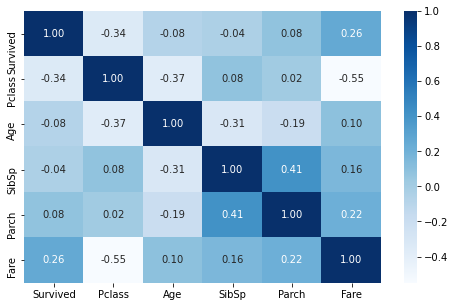

In [13]:
print(train.corr())
plt.figure(figsize=(8,5))
sns.heatmap(train.corr(), cmap='Blues', annot=True, fmt='.2f')

Pclass and Fare are most correlated with survival status. One interesting finding: Age and Pclass are negatively correlated.

In [20]:
# Compare mean numeric values for both survival status
pd.pivot_table(train, index = 'Survived', values = ['Age', 'SibSp', 'Parch', 'Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


Some interesting findings here that make a lot of sense intuitively: people who survived were averagely two years younger than those who didn't; people who purchased a more expensive ticket averagely had a better survival rate.

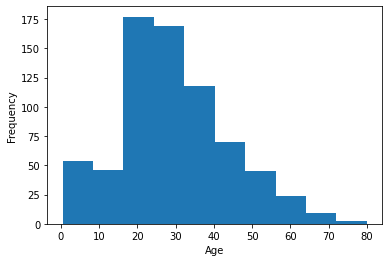

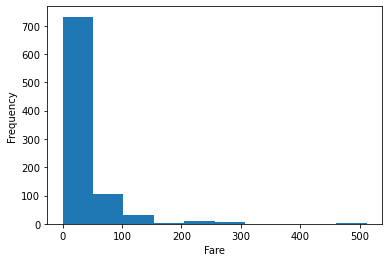

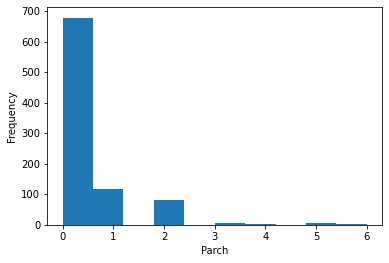

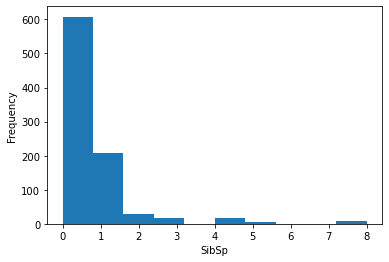

In [23]:
# Visualize the distribution of numeric categories 
for column in ['Age', 'Fare', 'Parch', 'SibSp']:
    train[column].plot(kind = 'hist')
    plt.xlabel(column)
    plt.show()

Like I mentioned above, the four numeric variables have different ranges, so I will use StandardScaler to change their values to a common scale to remove model's bias towards Fare or Age, which have a larger value range.

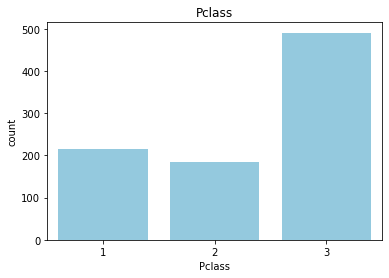

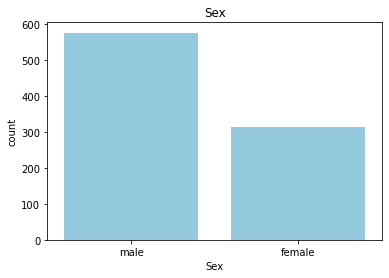

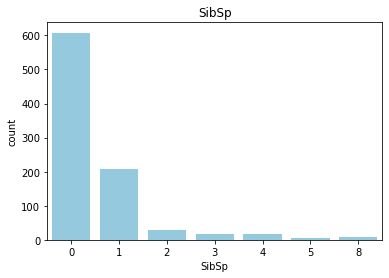

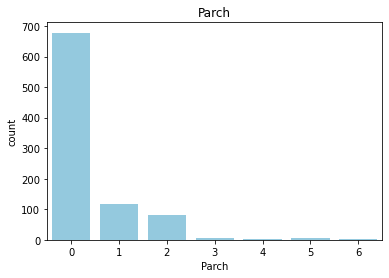

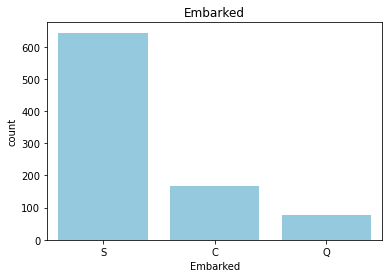

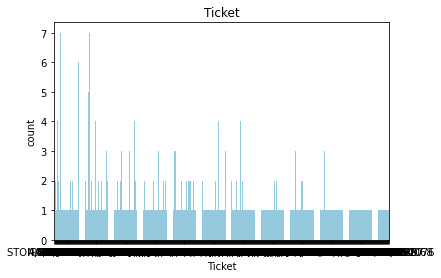

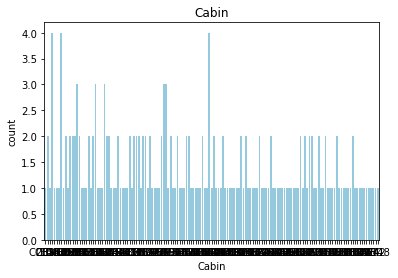

In [33]:
# Use a countplot to check the distribution of category variables
for column in ['Pclass', 'Sex', 'SibSp','Parch','Embarked', 'Ticket', 'Cabin']:
    sns.countplot(data=train, x=column, color='skyblue').set_title(column)
    plt.show()

In [44]:
# Compare survival rate across different categories
# Included SipSp and Parch 
for column in ['Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch']:
    print(pd.pivot_table(train, index='Survived', columns=column, values='Ticket', aggfunc='count'))
    print()

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119

Sex       female  male
Survived              
0             81   468
1            233   109

Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217

SibSp         0      1     2     3     4    5    8
Survived                                          
0         398.0   97.0  15.0  12.0  15.0  5.0  7.0
1         210.0  112.0  13.0   4.0   3.0  NaN  NaN

Parch         0     1     2    3    4    5    6
Survived                                       
0         445.0  53.0  40.0  2.0  4.0  4.0  1.0
1         233.0  65.0  40.0  3.0  NaN  1.0  NaN



## Feature Engineering - Training Dataset

- Three interesting columns that I will use to create more features: Name, Ticket, and Cabin

In [69]:
# Create a new column that extracts the first string character of Cabin
train['Cabin_Letter'] = train['Cabin'].apply(lambda x:0 if pd.isna(x) else x[0])

# Create a new column that indicates how many cabins each individual owns
train['Cabin_Total'] = train['Cabin'].apply(lambda x:0 if pd.isna(x) else len(x.split(' ')))

In [77]:
# Pivot table to understand survival numbers across different cabin categories and different total cabin numbers
print(pd.pivot_table(train, index='Survived', columns='Cabin_Letter', values='Name', aggfunc='count'))
print()
print(pd.pivot_table(train, index='Survived', columns='Cabin_Total', values='Name', aggfunc='count'))

Cabin_Letter      0    A     B     C     D     E    F    G    T
Survived                                                       
0             481.0  8.0  12.0  24.0   8.0   8.0  5.0  2.0  1.0
1             206.0  7.0  35.0  35.0  25.0  24.0  8.0  2.0  NaN

Cabin_Total      0      1    2    3    4
Survived                                
0            481.0   58.0  7.0  3.0  NaN
1            206.0  122.0  9.0  3.0  2.0


It is very interesting that except people who didn't have cabins, people who had at least one cabin had an averagely higher survival rate. For example, for those who had one cabin, almost 75% survived; however, only less than half of people who didn't have a cabin survived. Based on the analysis of people who had more than one cabin, this is not a coincidence.

In [84]:
# Feature engineering using Name column, extracting title from each person's name
train['Title'] = train['Name'].apply(lambda x: x.split(' ')[1].split('.')[0])

In [86]:
pd.pivot_table(train, index='Survived', columns='Title', values='Name', aggfunc='count')

Title,"Billiard,",Capt,"Carlo,",Col,"Cruyssen,",Don,Dr,"Gordon,","Impe,",Jonkheer,...,"Pelsmaeker,","Planke,",Rev,"Shawah,","Steen,","Velde,","Walle,",der,the,y
Survived,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,NaN,3.0,1.0,...,1.0,3.0,6.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0
1,NaN,NaN,NaN,1.0,NaN,NaN,3.0,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0


In [87]:
train['Title'].value_counts()

Mr              502
Miss            179
Mrs             121
Master           40
Dr                7
Rev               6
y                 4
Impe,             3
Planke,           3
Mlle              2
Major             2
Gordon,           2
Col               2
Cruyssen,         1
Billiard,         1
the               1
Pelsmaeker,       1
Velde,            1
Messemaeker,      1
Steen,            1
Shawah,           1
der               1
Mulder,           1
Carlo,            1
Mme               1
Ms                1
Melkebeke,        1
Don               1
Walle,            1
Capt              1
Jonkheer          1
Name: Title, dtype: int64

In [107]:
# Feature engineering using Ticket column 
# Comparing how many tickets are fully numeric
# Extracting
train['Ticket_Numeric'] = train.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
train['Ticket_Letter'] = train.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) >0 else 0)

In [113]:
train['Ticket_Numeric'].value_counts()

1    661
0    230
Name: Ticket_Numeric, dtype: int64

## Data Processing

A few things that are very important:

- Create labels for train and test dataset to split them to avoid train the model using test dataset.
- Check for null values, depending on numeric or categorical values, I will inputt mean, median, mode, 0 or drop rows.
- Feature engineering based on the feature engineering using the train dataset.
- Standardize numerical values: Age, Fare, Parch, SibSp because of different value ranges.
- Create dummy variables for categorical variables because most machine learning models only take in numeric values.


In [159]:
data['train_dataset'] = data['Survived'].apply(lambda x:0 if pd.isna(x) else 1)

In [160]:
# Checking for null values: Age: 263 null values, Fare: 1 null value, Cabin: 1014 null values, Embarker: 2 null values
data.isnull().sum()

Survived          418
Pclass              0
Name                0
Sex                 0
Age               263
SibSp               0
Parch               0
Ticket              0
Fare                1
Cabin            1014
Embarked            2
train_dataset       0
dtype: int64

In [161]:
train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [162]:
test.isnull().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

In [163]:
# Dropping rows with null Embarked values because only training dataset has null Embarked values
data.dropna(subset=['Embarked'], inplace=True)
# Fill Age and Fare null values with mean values
data['Age'].fillna(data['Age'].mean(), inplace=True)
data['Fare'].fillna(data['Fare'].mean(), inplace=True)

In [164]:
# Feature engineering using the techniques in the section above
data['Cabin_Letter'] = data['Cabin'].apply(lambda x:0 if pd.isna(x) else x[0])
data['Cabin_Total'] = data['Cabin'].apply(lambda x:0 if pd.isna(x) else len(x.split(' ')))
data['Title'] = data['Name'].apply(lambda x: x.split(' ')[1].split('.')[0])
data['Ticket_Numeric'] = data['Ticket'].apply(lambda x: 1 if x.isnumeric() else 0)
data['Ticket_Letter'] = data['Ticket'].apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) >0 else 0)

In [165]:
# Drop Name, Ticket, and Cabin columns
data.drop(columns = ['Name', 'Ticket', 'Cabin'], inplace=True)

In [166]:
# Create dummy variables for categorical variables
data = pd.get_dummies(data, columns=['Pclass', 'Sex', 'Embarked', 'Cabin_Letter', 'Cabin_Total', 'Title', 'Ticket_Numeric', 'Ticket_Letter'])

In [167]:
# Standardize numerica values
data[['Age','SibSp','Parch','Fare']] = StandardScaler().fit_transform(data[['Age','SibSp','Parch','Fare']])

In [179]:
# Split data into training and testing dataset for model building
X_train = data[data['train_dataset'] == 1]
X_test = data[data['train_dataset'] == 0]
y_train = data.loc[data['train_dataset'] == 1, 'Survived']
print('X_train: shape {}, X_test: shape{}, y_train: shape{}'.format(X_train.shape, X_test.shape, y_train.shape))

X_train: shape (889, 99), X_test: shape(418, 99), y_train: shape(889,)


In [180]:
# Drop Survived and train_dataset columns from training and testing datasets
X_train.drop(columns=['Survived', 'train_dataset'], inplace=True)
X_test.drop(columns=['Survived', 'train_dataset'], inplace=True)

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Model Building

In this section, I will use baseline models without fine-tuning hyperparameters and use K-Fold Cross Validation to give a more accurate measure of each model's performance. I will use four models: **Logistic Regression, K-Nearest Neighbors, Random Forest and XGBoost**.

Model Performance (Accuracy):

- Logistic Regression: 82.23%
- Support Vector Machine: 83.13% Works pretty well here because support vector machine works better for small datasets than larger ones
- K-Nearest Neighbors: 81.44%
- Random Forest Classifier: 81.21%
- XGBoost Classifier: 82.34%

In [184]:
# Logistic Regression
lr = LogisticRegression()
cv = KFold(n_splits=5, shuffle=True, random_state=1)
lr_scores = cross_val_score(lr, X_train, y_train, cv=cv)
print('Accuracy for Logistic Regression: ', lr_scores.mean())

Accuracy for Logistic Regression:  0.8222560782073256


In [196]:
# Support Vector Machine
svm = SVC()
svm_scores = cross_val_score(svm, X_train, y_train, cv=cv)
print('Accuracy for Support Vector Machine: ', svm_scores.mean())

Accuracy for Support Vector Machine:  0.8312575382466832


In [186]:
# K-Nearest Neighbors
knn = KNeighborsClassifier()
knn_scores = cross_val_score(knn, X_train, y_train, cv=cv)
print('Accuracy for K-Nearest Neighbors: ', knn_scores.mean())

Accuracy for K-Nearest Neighbors:  0.8144099536596204


In [193]:
# Random Forest Classifier
rf = RandomForestClassifier(random_state=1)
rf_scores = cross_val_score(rf, X_train, y_train, cv=cv)
print('Accuracy for Random Forest: ', rf_scores.mean())

Accuracy for Random Forest:  0.8121373706595569


In [194]:
# XGBoost Classifier
xgb = XGBClassifier(eval_metric='auc', 
                    use_label_encoder=False,
                    random_state=1)
xgb_scores = cross_val_score(xgb, X_train, y_train, cv=cv)
print('Accuracy for XGBoost: ', xgb_scores.mean())

Accuracy for XGBoost:  0.8234050657017711


## Hyperparameters Fine-Tuning

In [204]:
# Fine-tuning Logistic Regression Model
lr = LogisticRegression()
max_iter = [1000]
solver = ['liblinear', 'lbfgs', 'newton-cg']
penalty = ['l2']
c_values = [0.01,0.1,1,10,100]
lr_grid = dict(max_iter=max_iter,solver=solver, penalty=penalty, C=c_values)
lr_gs = GridSearchCV(lr, param_grid=lr_grid, cv=cv, verbose=1)
lr_best = lr_gs.fit(X_train, y_train)
print('Linear Regression Best Score: {}, Best Parameters: {}'.format(lr_best.best_score_, lr_best.best_params_))

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Linear Regression Best Score: 0.8245223132101822, Best Parameters: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    1.5s finished


In [208]:
# Fine-tuning Support Vector Machine
svm = SVC()
kernel = ['poly', 'rbf', 'sigmoid']
c_values = [100,50,10,1,0.1,0.001]
gamma = ['scale']
svm_grid = dict(kernel=kernel, C=c_values, gamma=gamma)
svm_gs = GridSearchCV(svm, param_grid=svm_grid, cv=cv, verbose=1)
svm_best = svm_gs.fit(X_train, y_train)
print('Support Vector Machine Best Score: {}, Best Parameters: {}'.format(svm_best.best_score_, svm_best.best_params_))

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Support Vector Machine Best Score: 0.8312575382466832, Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    4.0s finished


In [209]:
# Fine-tuning K-Nearest Neighbors
knn = KNeighborsClassifier()
n_neighbors = range(1,21,2)
metric = ['euclidean', 'manhattan', 'minkowski']
weights = ['uniform','distance']
knn_grid = dict(n_neighbors=n_neighbors, metric=metric, weights=weights)
knn_gs = GridSearchCV(knn, param_grid=knn_grid, cv=cv, verbose=1)
knn_best = knn_gs.fit(X_train, y_train)
print('K-Nearest Neighbors Best Score: {}, Best Parameters: {}'.format(knn_best.best_score_, knn_best.best_params_))

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


K-Nearest Neighbors Best Score: 0.8278677077382086, Best Parameters: {'metric': 'euclidean', 'n_neighbors': 17, 'weights': 'uniform'}


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    7.8s finished


In [212]:
# Fine-tuning Random Forest 
# Random Forest, as an ensemble machine learning algorithm, builds a number of decision trees and takes a 'majority wins' rule to decide 
# each observation's class. Because for each random forest model, it builds numerous trees, it takes more computational running time.
# I will use a Randomized Search CV first to narrow down the range for the best hyperparameters and use a Grid Search CV to 
# identify the best ones
n_estimators = [int(x) for x in np.linspace(start=200,stop=2000,num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10,110,num=11)]
max_depth.append(None)
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier(random_state=1)
rf_random_grid = RandomizedSearchCV(rf, 
                                    param_distributions=random_grid,
                                    cv=cv,
                                    n_iter=150,
                                    verbose=4,
                                    random_state=1,
                                    n_jobs=-1) 
rf_random_best = rf_random_grid.fit(X_train, y_train)
print('Random Forest Score: {}, Best Parameters: {}'.format(rf_random_best.best_score_, rf_random_best.best_params_))

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 589 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:  3.5min finished


Random Forest Score: 0.8368691677775661, Best Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': False}


In [214]:
rf=RandomForestClassifier(random_state=1)

random_grid_GS = {'n_estimators': [100,200,400,600],
                  'max_features': ['auto'],
                  'max_depth': [10,15,20,25],
                  'min_samples_split': [8,10,12],
                  'min_samples_leaf': [1,2,4],
                  'bootstrap': [False]}

rf_gs_grid = GridSearchCV(rf,
                          param_grid = random_grid_GS,
                          cv=cv,
                          n_jobs=-1)
rf_best = rf_gs_grid.fit(X_train, y_train)
print('Random Forest Score: {}, Best Parameters: {}'.format(rf_best.best_score_, rf_best.best_params_))

Random Forest Score: 0.8380118072748047, Best Parameters: {'bootstrap': False, 'max_depth': 25, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 100}


In [222]:
# Finet-tuning XGBoost model
# XGBoost Classifier is also a decision-tree based ensemble machine learning algorithem which uses a gradient boosting structure.
# It is different than Random Forest classifier because while decision trees are bulid independently of each other in Random Forest,
# they are built in succession in XGBoost classifier. Each tree is built to fit the residual error made by the previous one.
# Theoretically, it is an extremely effective model nowadays.
xgb = XGBClassifier(eval_metric='auc',
                    use_label_encoder=False)

xgb_random_grid = {"learning_rate": [0.1, 0.01, 0.001],
                   "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
                   "max_depth": [2, 4, 7, 10],
                   "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
                   "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
                   "min_child_weight": [1, 3, 5, 7],
                   "n_estimators": [100, 250, 500, 1000]}

xgb_rs = RandomizedSearchCV(xgb, 
                            param_distributions = xgb_random_grid,
                            n_iter = 150,
                            n_jobs=-1,
                            verbose = 1,
                            cv=cv,
                            random_state=1)

xgb_rs_best = xgb_rs.fit(X_train, y_train)
print('XGBoost Score: {}, Best Parameters: {}'.format(xgb_rs_best.best_score_, xgb_rs_best.best_params_))

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.5min


XGBoost Score: 0.8436043928140672, Best Parameters: {'subsample': 0.6, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 2, 'colsample_bytree': 1.0}


[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:  2.6min finished


In [223]:
xgb = XGBClassifier(eval_metric='auc',
                    use_label_encoder=False)

xgb_grid_GS = {"learning_rate": [0.1,1],
               "gamma" : [2],
               "max_depth": [7],
               "colsample_bytree": [0.5,0.7,1],
               "subsample": [0.6],
               "min_child_weight": [3,5],
               "n_estimators": [100,200,400]}

xgb_gs_grid = GridSearchCV(xgb, 
                           param_grid=xgb_grid_GS,
                           cv=cv,
                           n_jobs=-1, 
                           verbose=1)

xgb_best = xgb_gs_grid.fit(X_train, y_train)
print('XGBoost Best Score: {}, Best Parameters: {}'.format(xgb_best.best_score_, xgb_best.best_params_))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   21.9s finished


XGBoost Best Score: 0.8492414143337778, Best Parameters: {'colsample_bytree': 1, 'gamma': 2, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.6}


**After fine-tuning each model's hyperparameters, below is the result.**

| Model      | Baseline Performance | Tuned Performance |
| ----------- | ----------- |  ----------- | 
| Logistic Regression      |    82.23%    |   **82.45%**        |
| Support Vector Machine   |   83.13%      |  **83.13%**       |
| K-Nearest Neighbors |  81.44%    |     **82.79%**         |
| Random Forest  |   81.21%  |  **83.80%** |
| XGBoost Classifier  | 82.34% |  **84.92%**  |


**Results**

**-XGBoost Classifier has the best performance after tuning hyperparameters, so I will use it to predict survival status on the test dataset.**

In [225]:
y_hat = xgb_gs_grid.best_estimator_.predict(X_test)

In [229]:
PassengerId = range(892, 1310)
predicted_test = pd.DataFrame({'PassengerId': PassengerId, 'Survived': y_hat})
predicted_test.to_csv('test_results.csv', index=False)